
# Procrustes Transformation

This is a demonstration of the ways to do a procrustes tranformation on 3 buckets of the German Bundescorpus, the effects of the different ways of doing the transformations and the different ways of displaying the movement of words throughout time.

Leading up to this, we divided the corpus into 3 buckets by year, without thought for a certain period of time. %TODO: look this up. Vectors were created on each bucket, and are (or should be) stored in the `data` folder underneath this one. If you want to give this a whirl without loading the vectors into memory (the largest is roughly 3Gb) then I have created 'test' versions of each, and I have noted where you have to change some code as we go along.

In [40]:
import pandas as pd
import numpy as np
import csv
from scipy.spatial.distance import cosine, cdist
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

Notes for paper:

lowercase and lemmatize?
stopwords
clustering?


## Import vectors

Note that the typical way to do this was with gensim, at the time I could not find a good guide on converting them from fasttext to gensim formatting, I forged ahead with simple but non-optimized pandas and scipy functions.

In [41]:
def vector_reader(to_read):
    """Read a bucket of word vectors into memory
    Returns: a dataframe of vectors"""
    path = "data/vectors/"
    to_read = path + to_read
    return pd.read_csv(to_read,
                       sep="\t",
                       header=None,
                       index_col=0,
                       quoting=csv.QUOTE_NONE)

In [42]:
bucket_1_vec = vector_reader("bucket_1_vecs.tsv")
bucket_2_vec = vector_reader("bucket_2_vecs.tsv")
bucket_3_vec = vector_reader("bucket_3_vecs.tsv")

# Comment above and uncomment the following in order to run the smaller versions
# bucket_1_vec = vector_reader("bucket_1_vecs_test.tsv")
# bucket_2_vec = vector_reader("bucket_2_vecs_test.tsv")
# bucket_3_vec = vector_reader("bucket_3_vecs_test.tsv")

print (bucket_1_vec.shape)
print (bucket_2_vec.shape)
print (bucket_3_vec.shape)

print(bucket_1_vec.index.values)
#print(bucket_2_vec.index.values)
bucket_1_vec.head()

(1646298, 100)
(1101884, 100)
(1434110, 100)
[nan '.' ',' ... 'Ax^t' 'Ansiedlung^' '^Schweizer^Eolonie']


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
NaN,1.412780e-04,-1.916210e-04,1.060960e-04,-4.928630e-05,5.034650e-05,-2.132520e-04,5.642930e-05,5.500130e-05,2.752550e-05,-9.898410e-05,...,-2.890100e-04,-5.756060e-06,-1.287030e-04,-1.396430e-04,1.789840e-04,-1.939450e-04,1.593120e-04,-1.627520e-05,2.421740e-05,1.590010e-04
.,3.932250e-09,-1.066140e-09,2.482770e-09,-7.607690e-10,7.665060e-10,-4.884010e-09,2.537460e-09,1.609670e-09,-4.553350e-11,-1.040860e-09,...,-4.135980e-09,-7.350390e-10,-1.566900e-09,-2.683600e-09,1.229970e-09,-2.148460e-09,5.799510e-09,-1.056850e-09,-1.804860e-09,1.878990e-09
",",2.433030e-04,-1.662700e-04,8.719520e-05,-2.596680e-05,3.961520e-05,-2.343060e-04,9.317980e-05,1.020380e-04,8.590840e-05,-1.497570e-04,...,-1.934970e-04,-9.563740e-05,5.457850e-08,-2.934850e-04,1.997040e-04,-1.242270e-04,2.640750e-04,-5.571640e-05,4.825090e-05,1.269300e-04
der,2.344360e-04,-3.199160e-04,2.129780e-04,-1.289410e-04,2.093350e-04,-1.647960e-05,1.504830e-04,-8.368480e-05,-4.808660e-05,-2.853510e-04,...,-5.899580e-04,-1.279630e-05,-2.679900e-06,-5.779900e-05,2.511930e-04,-3.634860e-04,2.013300e-04,5.640160e-05,9.680590e-05,1.369800e-04
und,8.236790e-05,-1.338730e-04,3.060720e-05,-4.135630e-05,4.714470e-05,-1.072960e-04,4.985720e-06,-1.222950e-05,1.318710e-05,-9.413860e-05,...,-1.633500e-04,-2.768580e-06,-1.838730e-05,-9.905270e-05,9.532330e-05,-7.548540e-05,1.125800e-04,-3.180220e-05,-3.215240e-05,8.421560e-05


## Make a common index

Some words go out of fashion, some words get created. This creates a common index for all 3 buckets so that we can accurately transform the vectors.

In [43]:
def union_index(vectors_1, vectors_2):
    """Create a common index made only of index values they have in common
    Input:
    vectors_1/_2: pandas dataframes, assumed to be word vectors in german
    
    Return:
    list of words common to the two vectors"""
    set_a = set(vectors_1.index.values)
    set_b = set(vectors_2.index.values)
    return list(set_a.intersection(set_b))

In [44]:
common_index_a = union_index(bucket_3_vec, bucket_2_vec)
common_index_b = union_index(bucket_2_vec, bucket_1_vec)

common_index = set(common_index_a).intersection(set(common_index_b))
print(len(common_index))

177406


## Removing duplicates and filtering bucket vectors

For some reason there seemed to be duplicate entries. This may not be the optimal way of doing it (averaging the vectors? Seeing if the vectors are the same/similar?) but this is a step that can easily be tweaked.

In [45]:
def filter_vectors(unfiltered_vector, common_index):
    """Filter based on an index and remove duplicates from a pandas dataframe
    Input:
    unfiltered_vector: a pandas dataframe
    common_index: a list of index items to filter for
    
    Return:
    a filtered pandas dataframe"""
    no_dupes_vector = unfiltered_vector[~unfiltered_vector.index.duplicated(keep='first')]
    return no_dupes_vector.filter(items=common_index, axis=0)

In [46]:
bucket_1_filtered = filter_vectors(bucket_1_vec, common_index)
bucket_2_filtered = filter_vectors(bucket_2_vec, common_index)
bucket_3_filtered = filter_vectors(bucket_3_vec, common_index)

print(bucket_1_filtered.shape)
print(bucket_2_filtered.shape)
print(bucket_3_filtered.shape)

(177406, 100)
(177406, 100)
(177406, 100)


## Procrustes by hand

The good people at stitchfix were kind to produce a really good article on latent stlye and a procrustes transformation:

https://multithreaded.stitchfix.com/blog/2018/06/28/latent-style/

This is the code they use.

In [47]:
def procrustes_transformer(vectors_1, vectors_2):
    """Perform a procrustes transformation on two vectors,
       aligning the second vector to the first vector"""
    vectors2_inv = np.linalg.pinv(vectors_2)
    T = np.dot(vectors2_inv, vectors_1)

    u, s, v = np.linalg.svd(T)
    si = np.eye(u.shape[0], v.shape[0])
    T_rot = np.dot(u, np.dot(si, v))
    return(pd.DataFrame(np.dot(vectors_2, T_rot), index=vectors_2.index))

In [48]:
procrustes_bucket_2 = procrustes_transformer(bucket_1_filtered, bucket_2_filtered)

In [49]:
procrustes_bucket_3 = procrustes_transformer(procrustes_bucket_2, bucket_3_filtered)

## Cosine distance wrapper functions

The idea is to see which words preserve the most meaning throughout time.

In [50]:
def cosine_distance(x, df2):
    """For a given word vector, get the cosine similarity in another dataframe
    
    Inputs:
    x - Pandas series (a row from a dataframe)
    df2 - Pandas dataframe
    
    Return: The cosine distance between the two vectors"""
    return cosine(x, df2.loc[x.name])

def cosine_distance_single(x, word_vector):
    return cosine(x, word_vector)


## Find similarities over time

Having undergone the procrustes transformation, we can now see which words maintained their meaning over the different buckets.

Note that the lower the cosine distance, the closer they are together (forgive me for being obvious, but these are the sorts of things I mess up) in meaning.

In [51]:
words_similarity = bucket_1_filtered.apply(cosine_distance,
                                            args=(procrustes_bucket_2,),
                                            axis=1)

word_similarity_1_2_our_procrustes = words_similarity.sort_values()
word_similarity_1_2_our_procrustes[:50]

0
ein                0.180449
ergibt             0.193492
als                0.205865
neuer              0.216644
im                 0.220819
betrachten         0.223447
bemerken           0.224288
erwähnen           0.226413
Wege               0.227998
um                 0.229528
Interesse          0.229599
mit                0.236676
Winters            0.243409
Staatsvertrag      0.245463
zur                0.247679
Bunde              0.249312
beliefen           0.249529
Rücksicht          0.249861
Erfolg             0.250401
belaufen           0.251265
verzeichnen        0.252557
dadurch            0.253315
ergeben            0.255232
verpflichtet       0.255475
ist                0.255976
Verzögerung        0.256385
Vorjahr            0.258385
einen              0.259161
Eingriff           0.260583
zugewiesen         0.261461
dem                0.261821
ergab              0.262006
Auslande           0.262668
belief             0.263466
befindet           0.264556
bedroht           

In [52]:
words_similarity = procrustes_bucket_2.apply(cosine_distance,
                                            args=(procrustes_bucket_3,),
                                            axis=1)

word_similarity_2_3_our_procrustes = words_similarity.sort_values()
word_similarity_2_3_our_procrustes[:50]

0
unterschätzenden       0.270872
Inland                 0.272757
inländische            0.281241
eingebüsst             0.282638
beliefen               0.286222
Ansteigen              0.295054
Einführen              0.296871
als                    0.297714
überschreiten          0.300335
befasste               0.301542
zuverlässige           0.307033
Ausscheiden            0.308209
Zusammenwirken         0.311039
verkaufen              0.313107
unterschätzende        0.313851
geringeren             0.315967
ein                    0.318408
Stückes                0.319476
Beeinträchtigung       0.321506
Aufmachungen           0.326085
Sowohl                 0.326613
Anwachsen              0.327864
Gerichts               0.328960
gegründete             0.331682
Geschäftsjahr          0.331688
belaufen               0.331871
Organ                  0.332939
Prinzip                0.333612
Souveränität           0.334933
grösser                0.335215
aus                    0.336361
Gewand

## Rough interpretation

The above seem relatively reasonable. It's a straightforward mix of pronouns, prepositions and state-based nouns. Just scanning (and assuming the same readout when this is run again) but between buckets 2-3, the word `Gerichts` and `Souveränität` stick out. Sovereinty stands out because it shows that the meaning of the authority of the state to rule remained stable from pre WWII into the modern era. Gerichts stands out because it shows the flaw in preprocessing. Were this to simply be Gericht, then we could plausibly say that the meaning of Court had remained stable during the same period. However the word `Gerichts` is a conjugated noun, presumably genitive. Meaning that the phrase `of the court` remained stable during the time period.

## Without Procrustes

What happens if we find similarities on the non-transformed vectors?

In [53]:
words_similarity = bucket_1_filtered.apply(cosine_distance,
                                            args=(bucket_2_filtered,),
                                            axis=1)

word_similarity_1_2 = words_similarity.sort_values()
word_similarity_1_2[:50]

0
Auslieferungsverträge    0.565220
publica                  0.583379
9543                     0.594248
2823                     0.603811
spetta                   0.613891
unerlaubtem              0.621735
Finanzinteressen         0.626057
Bundesunterstützung      0.629387
Lie-                     0.631759
Steigerang               0.633076
28,6                     0.636304
656                      0.638986
17114                    0.639197
Jawort                   0.639369
Tnurgau                  0.639420
Zeitlich                 0.642708
Gesetzesbeschluss        0.642847
hernach                  0.643026
^-4                      0.644156
Volery                   0.644263
Emblem                   0.644491
46,08                    0.645117
Platzmangel              0.645340
heftiger                 0.645821
Frühoder                 0.649343
14.96                    0.651995
Diskussionspunkte        0.653987
ablösen                  0.655099
10496                    0.655161
8464        

In [54]:
words_similarity = bucket_2_filtered.apply(cosine_distance,
                                            args=(bucket_3_filtered,),
                                            axis=1)

word_similarity_2_3 = words_similarity.sort_values()
word_similarity_2_3[:50]

0
Nutzungsrechten         0.553412
Entnahmen               0.577311
|B                      0.582307
hochgespannte           0.590264
Zust                    0.595540
Gläubige                0.597154
Briefumschläge          0.600388
Speiseleitung           0.608687
Amtsschreiber           0.609179
Marktplatz              0.613457
beratet                 0.614344
co                      0.624081
Sammelplätzen           0.627496
mög-                    0.628007
übersehbares            0.630441
Halten                  0.636224
D4                      0.636281
Kasino                  0.637019
Querprofilen            0.638598
Leitungsanlagen         0.639651
true                    0.642369
Auferstehung            0.642839
8617                    0.643065
Egbert                  0.643569
Scheiteltunnel          0.643873
direktem                0.645712
endgültiger             0.646981
2/12                    0.648694
Vergleichswege          0.649071
Melcher                 0.649653
Mariano 

## Not as good

It's marked by numbers, what looks like errors, family names and even an English word. And of course, they're probably right. The meaning of `2/12` certainly hasn't changed, but it definitely doesn't help us all that much.

## Let's do a gut check with the scipy procrustes

The `spatial.procrustes` function normalizes the data before calling `linalg.procrustes`.

In [55]:
bucket_1_x, bucket_2_x, disparity = procrustes(bucket_1_filtered,
                                               bucket_2_filtered)

bucket_2_x_df = pd.DataFrame(bucket_2_x, index=bucket_2_filtered.index)
bucket_1_x_df = pd.DataFrame(bucket_1_x, index=bucket_1_filtered.index)

In [56]:
words_similarity_x = bucket_1_x_df.apply(cosine_distance,
                                            args=(bucket_2_x_df,),
                                            axis=1)

word_similarity_1_2_x = words_similarity_x.sort_values()
word_similarity_1_2_x[:50]

0
Bd          0.097121
Jahrg.      0.100559
.           0.103828
,           0.115165
in          0.115210
den         0.118867
;           0.123158
und         0.124019
2           0.128857
NaN         0.132609
von         0.135196
(           0.138253
der         0.138599
ist         0.138630
)           0.139846
4           0.141960
Bern        0.143558
7           0.146299
5           0.146303
6           0.150642
im          0.151114
11.         0.154885
3           0.155698
November    0.155988
!           0.157164
dem         0.160502
mit         0.162766
5.          0.164346
die         0.165762
des         0.165947
Mai         0.166256
21          0.166777
8.          0.167006
26.         0.167378
8           0.167434
20.         0.168955
21.         0.169138
9.          0.169598
zu          0.169952
9           0.170594
14.         0.171775
22          0.171956
23.         0.172200
2.          0.173453
19.         0.174780
12.         0.176704
7.          0.177300
6.         

## Similar problem

Numbers and punctuation (although a significant change in punctuation would be very interesting). This one is interesting in the sense that it's a mix of numbers and then prepositions and articles.

## Orthogonal procrustes

This should be more similar to our hand-written function.

In [57]:
# produces the matrix that creates the transformation
R, s = orthogonal_procrustes(bucket_1_filtered,
                             bucket_2_filtered)

# transform the bucket
bucket_2_y = np.dot(bucket_2_filtered, R.T) * s

bucket_2_y_df = pd.DataFrame(bucket_2_y, index=bucket_2_filtered.index)
bucket_1_y_df = pd.DataFrame(bucket_1_filtered, index=bucket_1_filtered.index)

In [58]:
words_similarity_y = bucket_1_y_df.apply(cosine_distance,
                                            args=(bucket_2_y_df,),
                                            axis=1)

word_similarity_1_2_y = words_similarity_y.sort_values()
word_similarity_1_2_y[:50]

0
ergibt             0.187716
ein                0.189724
als                0.209466
im                 0.220747
neuer              0.222425
Interesse          0.225091
Wege               0.226182
betrachten         0.229878
mit                0.232401
um                 0.232479
bemerken           0.239063
Winters            0.241760
erwähnen           0.243314
Vorjahr            0.246707
Staatsvertrag      0.246710
Bunde              0.247118
belaufen           0.248601
zur                0.249695
dem                0.251768
verpflichtet       0.251994
beliefen           0.252713
ergeben            0.253387
Eingriff           0.254715
Rücksicht          0.254757
befindet           0.255214
Mangel             0.258414
Hinweis            0.259086
dadurch            0.259326
belief             0.259400
Erfolg             0.259841
einen              0.260273
Auslande           0.260910
ergab              0.261025
Dorfes             0.262571
Verzögerung        0.262675
gleichbedeutend   

## Next to each other

They look pretty similar

In [59]:
d = {"hand": word_similarity_1_2_our_procrustes[:50].index.values,
     "scipy": word_similarity_1_2_y[:50].index.values}

pd.DataFrame(data=d)

,hand,scipy
0,ein,ergibt
1,ergibt,ein
2,als,als
3,neuer,im
4,im,neuer
5,betrachten,Interesse
6,bemerken,Wege
7,erwähnen,betrachten
8,Wege,mit
9,um,um


## And the words that changed the most?

In [60]:
d = {"bucket_1_2": word_similarity_1_2_our_procrustes.sort_values(ascending=False).index.values,
     "bucket_2_3": word_similarity_2_3_our_procrustes.sort_values(ascending=False).index.values
    }

In [61]:
most_changed = pd.DataFrame(data=d)

In [62]:
most_changed[:50]

,bucket_1_2,bucket_2_3
0,Boecourt,Bundesblait
1,Allei,Drohen
2,Strassendamm,"0,865"
3,Haftpflichtansprüchen,Herrrn
4,Verstärkte,Häusel
5,"6,84",9992
6,ferste,Richtung-
7,8366,"3,445"
8,960.-,2.14
9,dh,Cüur


# Looking up words

Let's say that we wanted to see how the word kampf has change throughout the three buckets. From this point on we are going to be using the aligned bucket vectors that we did by hand (code from stitchfix).

In [63]:
#bucket_1_filtered
#procrustes_bucket_2
#procrustes_bucket_3

In [64]:
def most_similar(key_word, vectors, n=100):
    # get the vector of the word we want to compare
    to_test_vector = vectors.loc[key_word]
    
    # compute the cosine distance for each word
    new_data_frame = vectors.apply(cosine_distance_single,
                                   args=(to_test_vector,),
                                   axis=1)
    #sort
    new_data_frame = new_data_frame.sort_values(ascending=True)[:n]
    return new_data_frame

In [65]:
kraft_1 = most_similar("Kraft", bucket_1_filtered)
print(kraft_1.index.values)

['Kraft' 'getreten' 'treten' 'Rechtskraft' 'getretenen' 'Kratt'
 'enthaltend' 'Wirksamkeit' 'gesetzt' 'Funktion' 'tritt'
 'Entschädigungssätzen' 'Mindestfracht' 'einbezogen' 'trete' 'Graphisches'
 'außer' 'zerfällt' 'Fässern' 'abzubremsen' 'Frachtsätze' 'getretene'
 'gesetzten' 'Geltung' 'emporgearbeitet' 'klarer' 'tretende' 'tretender'
 'lter' 'Flaschen-' 'Blöcken' 'wodurch' 'tretenden' 'ehrliches' 'zerlegt'
 'Ausnahmetarife' 'geschälten' 'semaines' 'Sonnenblumenöl' 'ausgehrochen'
 'Nachtrag' 'gesteckt' 'welcher' 'Betriebszwecken' 'welchem' 'verbündeter'
 'rückwirkende' 'obgenannteii' 'zusätzlichen' 'rückwirkender' 'Neuigkeit'
 'verbleiben' 'nachstehende' 'Fernen' 'Gesundheitszeugnis' 'Tarif' 'II6'
 'Hauptsache' 'voller' 'Drahtkörbe' 'geographischer' 'setzen' 'bewegende'
 'unveränderter' 'Wien' 'Mehrheitsentscheid' 'vertragslose' 'Betracht'
 'vollziehbar' 'aufruft' 'igkeit' 'Lagermiete' 'Aktivität' 'Malan'
 'Camuns' 'Schädigungsabsicht' 'geänderter' 'Ausnahmetarif'
 'ungebrochener' 'F

In [66]:
def similar_wrapper(b_1, b_2, b_3, key_word, n=100):
    k_w_1 = most_similar(key_word, b_1, n=n).index.values
    k_w_2 = most_similar(key_word, b_2, n=n).index.values
    k_w_3 = most_similar(key_word, b_3, n=n).index.values
    
    d = {
        "bucket_1": k_w_1,
        "bucket_2": k_w_2,
        "bucket_3": k_w_3
    }
    return pd.DataFrame(d)

In [67]:
power_through_history = similar_wrapper(bucket_1_filtered,
                                        procrustes_bucket_2,
                                        procrustes_bucket_3,
                                        "Kraft")

In [68]:
print(power_through_history.to_string())

                bucket_1               bucket_2               bucket_3
0                  Kraft                  Kraft                  Kraft
1               getreten               getreten               getreten
2                 treten                 treten                 treten
3            Rechtskraft                gesetzt             getretenen
4             getretenen             getretenen              getretene
5                  Kratt            Wirksamkeit                gesetzt
6             enthaltend                  tritt                   trat
7            Wirksamkeit                   eten                 ausser
8                gesetzt              getretene                Theodul
9               Funktion                 sofort            Erscheinung
10                 tritt              tretenden                  tritt
11  Entschädigungssätzen                bleiben                 setzen
12         Mindestfracht      Ratifikationsakte               tretende
13    

# Visualization

## T-SNE

To try to visualize the differences between words, we'll start by trying the  T-distributed stochastic neighbor embedding (T-SNE). If you're unfamiliar with the tool, [here is the guy who invented it explaining it at a Google talk](https://www.youtube.com/watch?v=RJVL80Gg3lA&list=UUtXKDgv1AVoG88PLl8nGXmw). That video is well worth your time. If you want a deeper dive, [here's the guy's webpage devoted to it](https://lvdmaaten.github.io/tsne/).

But if you don't feel like looking at it, the technique basically figures out in high dimensional space how likely two points are to occur near each other and then maps it in low dimensional space in a way that is similar to that high dimensional probability. IE points that are likely to be closer together in high dimensional space are equally likely to be close in low dimensional space.

Here we explore two methods of doing TSNE, one where we build the TSNE model on each separate set of buckets and then doing it on the combined buckets.

Here is a word list that I came up with, just off of the top of my head. 

In [69]:
word_list = ["Kraft", "Zoll", "Steur", "Macht", "Schweiz", "Geld", "Krieg", "Sieg", "Kirche", "Recht"]

In [70]:
bucket_1_wl = bucket_1_filtered.filter(items=word_list, axis=0)
bucket_2_wl = procrustes_bucket_2.filter(items=word_list, axis=0)
bucket_3_wl = procrustes_bucket_3.filter(items=word_list, axis=0)

In [71]:
def get_x_y(values):
    x = list()
    y = list()
    for value in values:
        x.append(value[0])
        y.append(value[1])
        
    return x, y


def tsne_plot_separate(vectors_a, vectors_b, vectors_c):
    tsne_model = TSNE(n_components=2, init='pca')
    new_values_a = tsne_model.fit_transform(vectors_a)
    new_values_b = tsne_model.fit_transform(vectors_b)
    new_values_c = tsne_model.fit_transform(vectors_c)
    
    labels = vectors_a.index.values
    
    x, y = get_x_y(new_values_a)
        
    plt.figure(figsize=(16,16))
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color='b')
        plt.annotate(labels[i],
                     xy =(x[i], y[i]),
                     xytext=(5,2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=15)

        
    x, y = get_x_y(new_values_b)
    labels = vectors_b.index.values
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color='r')
        plt.annotate(labels[i],
                     xy =(x[i], y[i]),
                     xytext=(5,2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=15)
        
    x, y = get_x_y(new_values_c)
    labels = vectors_c.index.values
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color='y')
        plt.annotate(labels[i],
                     xy =(x[i], y[i]),
                     xytext=(5,2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=15)
    
        
    plt.show()

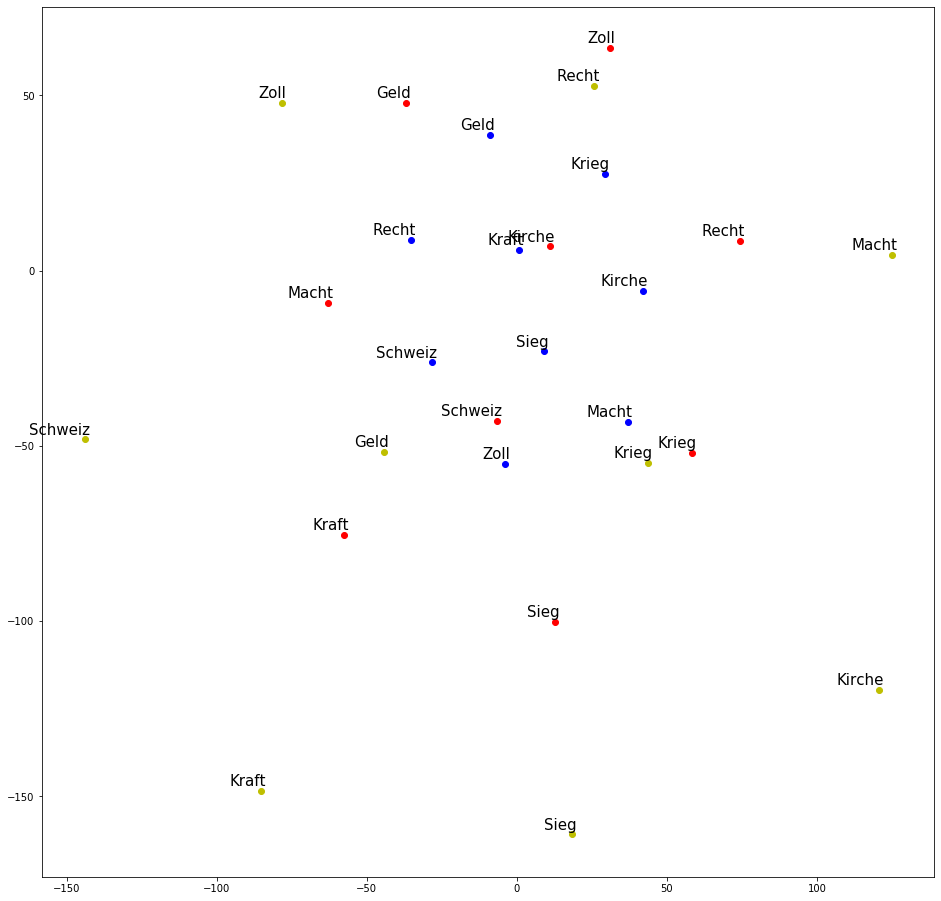

In [72]:
tsne_plot_separate(bucket_1_wl, bucket_2_wl, bucket_3_wl)

## And if we run it together

It looks like there's an error, too big. In previous experiments with smaller dummy vectors it creates a very uniform, evenly distributed spread, like the seeds in a pinecone. And honestly, since we have already aligned the vectors, there's no reason to project them into the same space again, in fact it goes counter to what we are trying to accomplish. But I leave it here in case and have turned it into a text cell.

def tsne_plot_together(vectors_a, vectors_b):
    totes = pd.concat([vectors_a, vectors_b])
    tsne_model = TSNE(n_components=2)
    new_values = tsne_model.fit_transform(totes)
    
    cutoff = len(vectors_a.index.values)-1
    
    labels = list(vectors_a.index.values) + list(vectors_b.index.values)
    
    x, y = get_x_y(new_values)
    
    plt.figure(figsize=(16,16))
    
    for i in range(len(x)):
        if i < cutoff:
            color='b'
        else:
            color='r'
        plt.scatter(x[i], y[i], color=color)
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom',
                    fontsize=15)
        
    plt.show()

tsne_plot_together(bucket_1_wl, bucket_2_wl)

### Let's try it with PCA

PCA is a really cool tool. If you are new to it, this is, in my opinion the only thing you need to read: [A tutorial on Principal Components Analysis by Lindsay I Smith](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf)

The long and short of it is that it takes the covariance of every variable and then takes the eigenvectors of that matrix. So if we just take the top two, and plot the matrix defined by those vectors as the x and y, well that's a good way of summarizing high dimensional data. You're projecting it linearly in a maximally variant way. But seriously, that link above will take you from A to B better than anything else out there. And honestly, I would read it as a prelude to any sort of dimension analysis that you might be investigating.

Might give us some cleaner visualizations.

In [75]:
def PCA_plot(vectors_a, vectors_b, vectors_c):
    pca = PCA(n_components=2)
    pca.fit(vectors_a)
    
    new_matrix = pca.transform(vectors_a)
    new_matrix_b = pca.transform(vectors_b)
    new_matrix_c = pca.transform(vectors_c)
    
    labels = vectors_a.index.values
    labels_b = vectors_b.index.values
    labels_c = vectors_c.index.values
    
    plt.figure(figsize=(16,16))
    
    for i, label in enumerate(labels):
        plt.scatter(new_matrix[i][0], new_matrix[i][1], color='b')
        plt.annotate(label,
                    xy=(new_matrix[i][0], new_matrix[i][1]),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom',
                    fontsize=15)
        
    for i, label in enumerate(labels_b):
        plt.scatter(new_matrix_b[i][0], new_matrix_b[i][1], color='r')
        plt.annotate(label,
                    xy=(new_matrix_b[i][0], new_matrix_b[i][1]),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom',
                    fontsize=15)
        

    for i, label in enumerate(labels_c):
        plt.scatter(new_matrix_c[i][0], new_matrix_c[i][1], color='y')
        plt.annotate(label,
                    xy=(new_matrix_c[i][0], new_matrix_c[i][1]),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom',
                    fontsize=15)
    #plt.xlim(-0.0015, 0.003)
    #plt.ylim(-0.001, 0.002)
        
    plt.show()

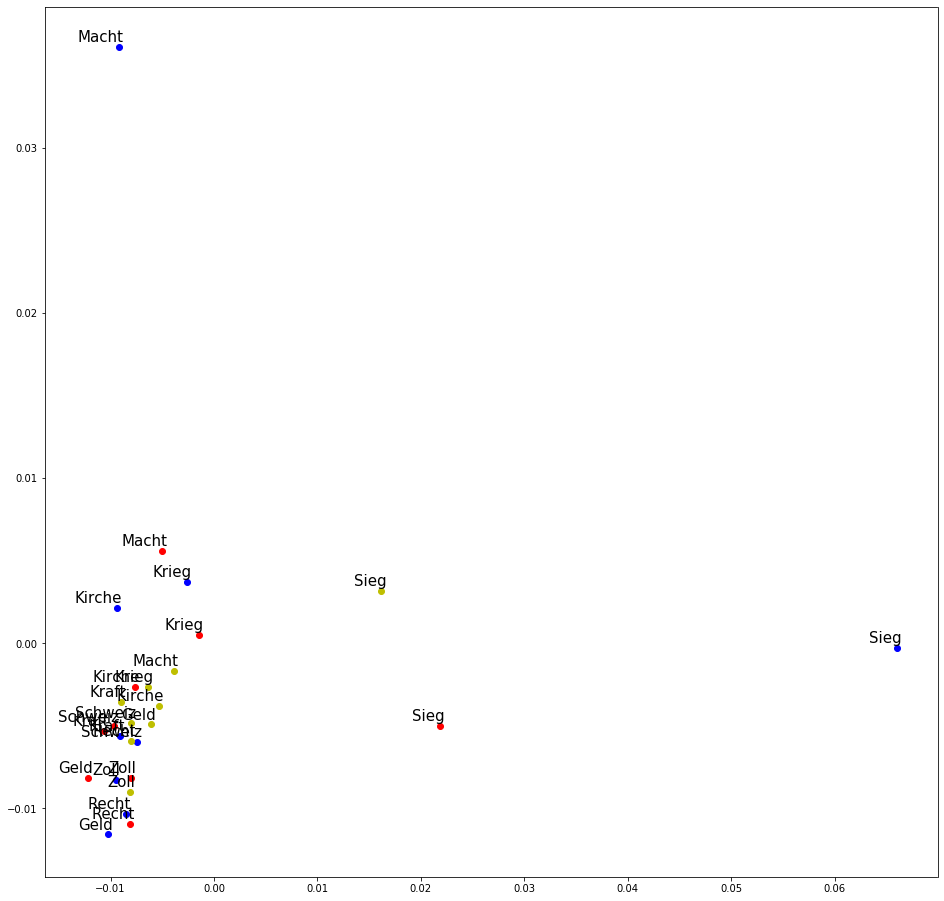

In [76]:
PCA_plot(bucket_1_wl, bucket_2_wl, bucket_3_wl)

### Interesting

Noisy, hard to see the smaller stuff. I will point out that Recht, Geld and Zoll are quite close together. I will point out that I've done this a couple times, and this is the general 'shape' of a PCA visualization.

But let's see if we can plot individual words as they move through semantic space and time!

In [80]:
def plot_word(key_word, vector_a, vector_b, vector_c):
    pca = PCA(n_components=2)
    pca.fit(vector_c)

    new_matrix_3 = pca.transform(vector_c)
    new_matrix_2 = pca.transform(vector_b)
    new_matrix_1 = pca.transform(vector_a)

    index_3 = vector_c.index.tolist().index(key_word)
    to_plot_3 = new_matrix_3[index_3]

    plt.figure(figsize=(16,16))

    plt.scatter(to_plot_3[0], to_plot_3[1], color='b')
    plt.annotate(key_word,
                xy=(to_plot_3[0], to_plot_3[1]),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom',
                fontsize=15)

    index_2 = vector_b.index.tolist().index(key_word)
    to_plot_2 = new_matrix_2[index_2]

    plt.scatter(to_plot_2[0], to_plot_2[1], color='b')
    plt.annotate(key_word,
                xy=(to_plot_2[0], to_plot_2[1]),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom',
                fontsize=15)

    index_1 = vector_a.index.tolist().index(key_word)
    to_plot_1 = new_matrix_1[index_1]

    plt.scatter(to_plot_1[0], to_plot_1[1], color='y')
    plt.annotate(key_word,
                xy=(to_plot_1[0], to_plot_1[1]),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom',
                fontsize=15)

    plt.arrow(to_plot_3[0],
              to_plot_3[1],
              (to_plot_2[0]-to_plot_3[0])*0.98,
              (to_plot_2[1]-to_plot_3[1])*0.98,
               length_includes_head=True,
               color='black',
               width=0.00001)

    plt.arrow(to_plot_2[0],
              to_plot_2[1],
              (to_plot_1[0]-to_plot_2[0])*0.98,
              (to_plot_1[1]-to_plot_2[1])*0.98,
               length_includes_head=True,
               color='black',
               width=0.00001)

    plt.show()

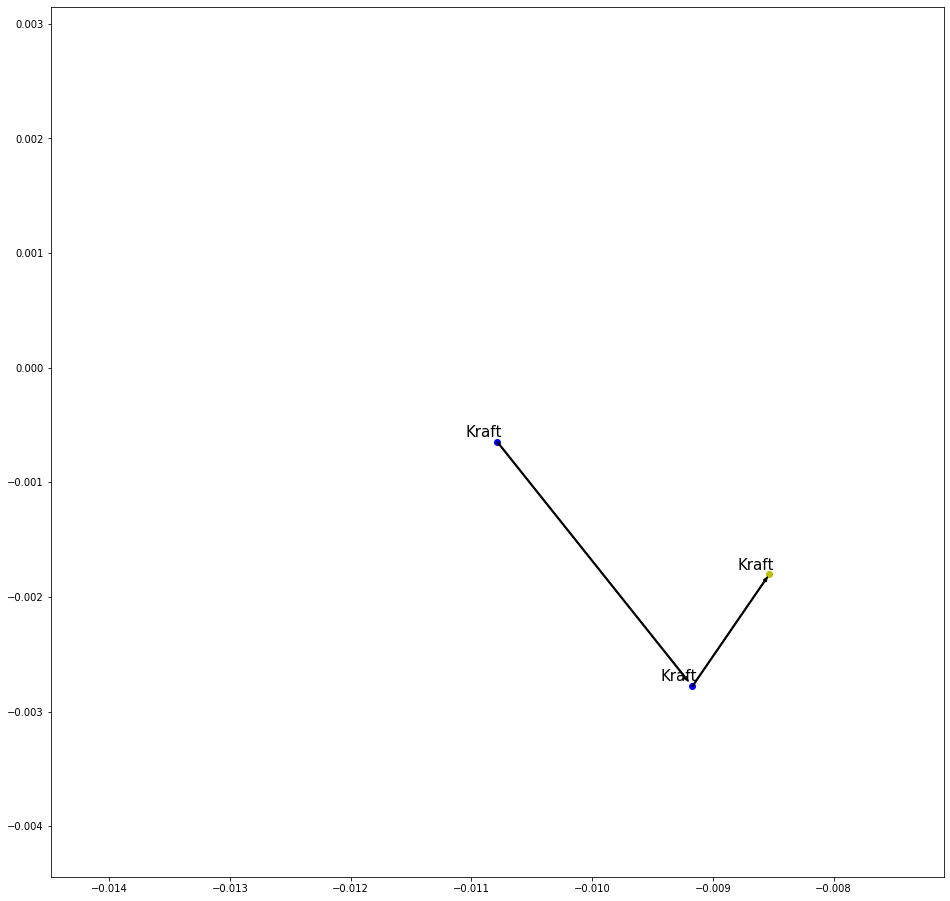

In [81]:
plot_word("Kraft", bucket_1_wl, bucket_2_wl, bucket_3_wl )

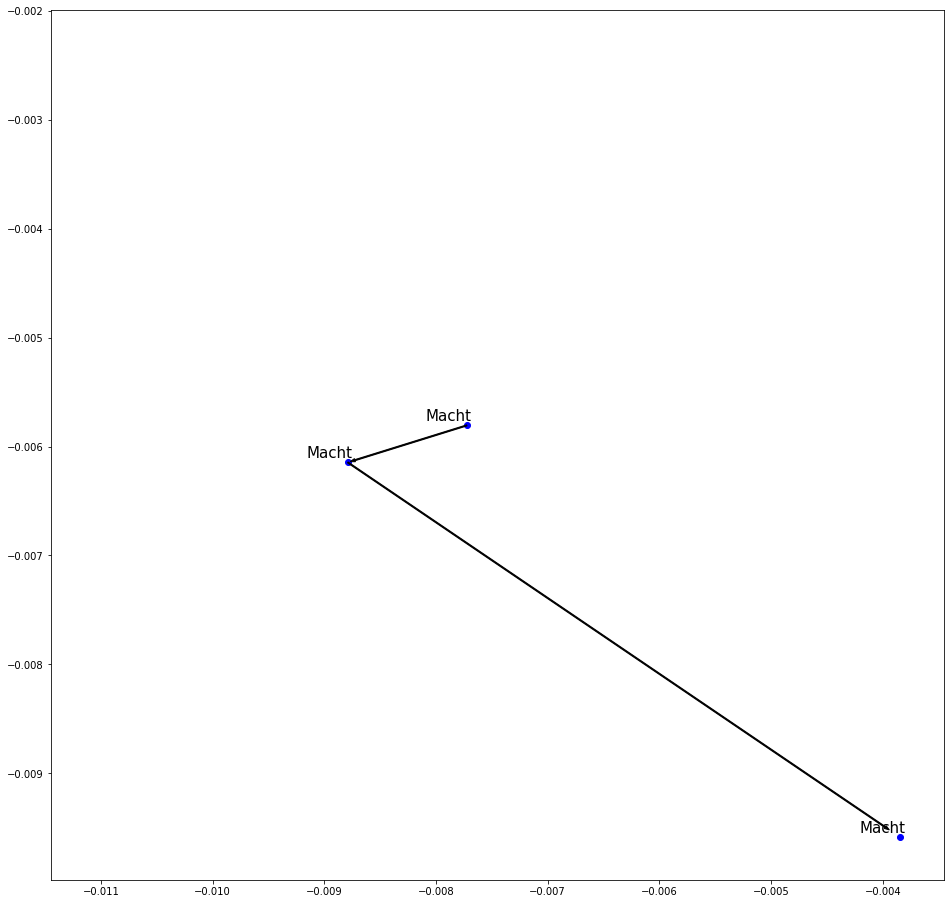

In [79]:
plot_word("Macht", bucket_1_wl, bucket_2_wl, bucket_3_wl )

## Final idea

In one of the papers, they withheld a year from each bucket and then, did a regression to see whether it was possible to predict what bucket the witheld year came from (it did). And then, given a successfull regression, you could see which word or words were the best at predicting the withheld year, the idea being that those were the words that best summarized the bucket.

Now, I did not withold any years when creating the buckets, but I thought maybe just averaging the vectors for each bucket and then seeing which word was the closest, then that might be useful as well. Or not.

In [82]:
average_1 = bucket_1_filtered.mean(axis=0)

In [83]:
new_data_frame = bucket_1_filtered.apply(cosine_distance_single,
                                           args=(average_1,),
                                           axis=1)

new_data_frame = new_data_frame.sort_values(ascending=True)[:50]
new_data_frame

0
17580                0.472508
t§                   0.492195
5230                 0.495026
lif                  0.508857
18.01                0.517645
5026                 0.519435
41,093               0.519896
s-                   0.520137
13231                0.521845
<L>                  0.522475
e\                   0.524327
4,26                 0.528810
7,13                 0.529609
0390                 0.533831
12573                0.535507
ZL                   0.535687
2,721                0.536371
17830                0.540152
ti*                  0.540844
£H                   0.541090
106,2                0.541363
12247                0.541604
staatsgefährliche    0.542768
10140                0.544501
10,60                0.545482
5208                 0.547142
46,7                 0.547271
Sa                   0.547523
8,263                0.549744
tiere                0.550207
16812                0.550475
M                    0.551859
Jfl                  0.552169
121,9   

### Very interesting and weird

Okay so the numbers are clearly overrepresented here, but the word 'staatsgefaehrliche' is the highest rated one!!
We'll just see what the other two look like.

In [84]:
average_2 = procrustes_bucket_2.mean(axis=0)

In [85]:
new_data_frame = procrustes_bucket_2.apply(cosine_distance_single,
                                           args=(average_2,),
                                           axis=1)

new_data_frame = new_data_frame.sort_values(ascending=True)[:50]
new_data_frame

0
1,370             0.437773
217,4             0.438040
s|                0.444817
1,256             0.452873
2,08              0.453926
e|                0.465220
15,02             0.470388
0,83              0.471131
1,593             0.474175
5868              0.480932
2,078             0.482104
4,83              0.482411
46,7              0.482663
3,290             0.483221
1,045             0.484991
3,330             0.485817
2,029             0.486347
3,714             0.486371
1,371             0.487773
4546              0.488314
4,033             0.489161
i9                0.490522
S83               0.491190
392,6             0.491300
1,565             0.491770
67,9              0.493076
|s                0.493178
1,298             0.493613
2,812             0.493803
8761              0.494798
•Ü                0.497821
s«                0.498013
1,574             0.498110
1,281             0.500366
1,437             0.500439
5/2               0.500498
2,988             0.501020

## Okay... Beans

In [86]:
average_3 = procrustes_bucket_3.mean(axis=0)

In [87]:
new_data_frame = procrustes_bucket_3.apply(cosine_distance_single,
                                           args=(average_3,),
                                           axis=1)

new_data_frame = new_data_frame.sort_values(ascending=True)[:50]
new_data_frame

0
1,78               0.421627
96,0               0.429554
Duillier           0.429586
1600-              0.435889
Romanel            0.443598
lungs              0.446387
Tri                0.447906
contrôleur         0.448024
Bart               0.449362
Roh                0.449748
t-                 0.451950
Gingins            0.453686
préposé            0.456245
Neuchatel          0.460232
Fc                 0.460808
Gauchat            0.461446
ÏJ                 0.462356
Mouthon            0.462840
Communes           0.463084
6,20               0.467924
Hosig              0.470027
7,93               0.474366
Industriel         0.474720
Deillon            0.474831
Tamò               0.474905
Totil              0.475846
Leibacher          0.478433
pus                0.479067
Hold               0.481445
Reuter             0.481917
17600              0.483293
Froidevaux         0.485031
dont               0.486657
Villars-Mendraz    0.486976
Maj                0.487823
Sta               

## This seems to have a more French bent.

I'm going to call that experiment a dud, but worth the effort.

# That's a brief tour of Procrustes.

I think that this is a pretty good start and at the very least I've built some tools that may be used. I'll discuss some of the directions I think it could go in the report that I'm writing up.